In [3]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.stats import wilcoxon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [5]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [6]:
path = "/Users/wassilyminkow/Desktop/d-lactate/"
# path = "/Users/wassilyminkow/Data/test/"

In [5]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) == 2:
        paths[key] = li

In [6]:
def standardize_data_format(data):
    
    rec = data["Record"].unique()

    if int(rec[0].split("-")[1]) < int(rec[1].split("-")[1]):
        data = data.replace(rec[0], "Day 1").replace(rec[1], "Day 2")

    elif int(rec[0].split("-")[1]) > int(rec[1].split("-")[1]):
        data = data.replace(rec[0], "Day 2").replace(rec[1], "Day 1")

    elif int(rec[0].split("-")[0]) < int(rec[1].split("-")[0]):
        data = data.replace(rec[0], "Day 1").replace(rec[1], "Day 2")

    elif int(rec[0].split("-")[0]) > int(rec[1].split("-")[0]):
        data = data.replace(rec[0], "Day 2").replace(rec[1], "Day 1")
        
    return data

In [9]:
# total hours = 6
min_per_epoch = 5
n_epocs = 72

# test
# min_per_epoch = 1/60
# n_epocs = 10

order = 400
a = 1 

# set data frame

data = []

bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = ["Power", "Power {}-{}".format(bands[0,0], bands[0,1]), "Power {}-{}".format(bands[1,0], bands[1,1])]

for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))  
        
data.append("Acceleration")
data.append("Subject")
data.append("Record")

data_names = pd.DataFrame(columns=data)

data = data_names.copy()

for key, value in paths.items():
    
    data_subject = data_names.copy()
    
    for name in value:
        
        # read EEG and acceleration data
        raw_data = mne.io.read_raw_bdf(name)
        channel_names = raw_data.info["ch_names"]
                    
        # get sampling rate of the data
        fs = round(raw_data.info['sfreq'])
        
        # get EEG data as pandas DataFrame
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])

        # Calculate # of epochs and correspotding # of EEG samples for the EEG file for n_epocs
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = round(fs*SEC_PER_MIN*min_per_epoch)

        # data frame to write calculated data
        data_record = {}
        
        info = f'''
        Sampling Rate: {fs}
        # samples: {n_samples}
        # steps: {step}
        Channel names: {channel_names}
        '''
        
        print(info)
        
        # here we take each chan and calculate power for each epoch
        for chan in chans:

            # low-pass filter
            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_lo = filtfilt(b, a, df_epocs[chan]) # apply filter
            
            # high-pass filter
            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan])
            
            # band power data
            data_record.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_lo[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
            })
                    
        # acceleration data
        acc_sign = df_epocs[channel_names[-1]]
        data_record.update({
            "Acceleration": np.array(list(map(lambda i: (acc_sign.iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
                        })
        
        # make pandas data frame from record data
        data_record = pd.DataFrame(data_record)
        
        # add record info to data frame
        data_record["Record"] = name.split('/')[-1][:-10]
        data_record["Minutes"] = np.arange(0, n_epocs)*min_per_epoch
        
        data_subject = pd.concat([data_subject, data_record])
    
    data_subject = standardize_data_format(data_subject)
    data_subject["Subject"] = key
    data = pd.concat([data, data_subject])
        
data = data.reset_index(drop=True)

Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/RecV3_2_ang+/01-02-2019_14-22.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...

        Sampling Rate: 250
        # samples: 5400000
        # steps: 75000
        Channel names: ['Channel 1', 'Channel 2', 'Accelerometer']
        


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/RecV3_2_ang+/31-01-2019_15-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




        Sampling Rate: 250
        # samples: 5400000
        # steps: 75000
        Channel names: ['Channel 1', 'Channel 2', 'Accelerometer']
        
Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/#3_ang-/04-04-2019_14-55.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




        Sampling Rate: 500
        # samples: 10800000
        # steps: 150000
        Channel names: ['Channel 1', 'Channel 2', 'Accelerometer']
        
Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/#3_ang-/02-04-2019_14-44.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...

        Sampling Rate: 500
        # samples: 10800000
        # steps: 150000
        Channel names: ['Channel 1', 'Channel 2', 'Accelerometer']
        
Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/RecV3_3_ang+/01-02-2019_14-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...

        Sampling Rate: 250
        # samples: 5400000
        # steps: 75000
        Channel names: ['Channel 1', 'Channel 2', 'Accelerometer']
        
Extracting EDF parameters from /Users/wassilyminkow/Desktop/d-lactate/RecV3_3_ang+/31-01-2019_15-28.bdf...
BDF file detected
Setting channel info structure...


In [320]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [10]:
pylab.rcParams['figure.figsize'] = (30, 15)
sns.set(font_scale=1.5)

In [11]:
data.to_csv("d_lactate.csv")

In [180]:
data.to_csv("l_lactate.csv")

In [59]:
d_lactate = pd.read_csv('d_lactate.csv')

In [7]:
l_lactate = pd.read_csv('l_lactate.csv')

In [18]:
uq = data["Subject"].unique()
p_value = np.ones(uq.shape[0])

for i, sub in enumerate(uq):
    
    x = data[(data["Subject"]==sub) & (data["Record"]=="Day 1")]["Acceleration"]
    y = data[(data["Subject"]==sub) & (data["Record"]=="Day 2")]["Acceleration"]
    
    corr_th = 0.05/uq.shape[0]
    if wilcoxon(x, y)[1] < corr_th:
        data = data.replace(sub, sub+"+")

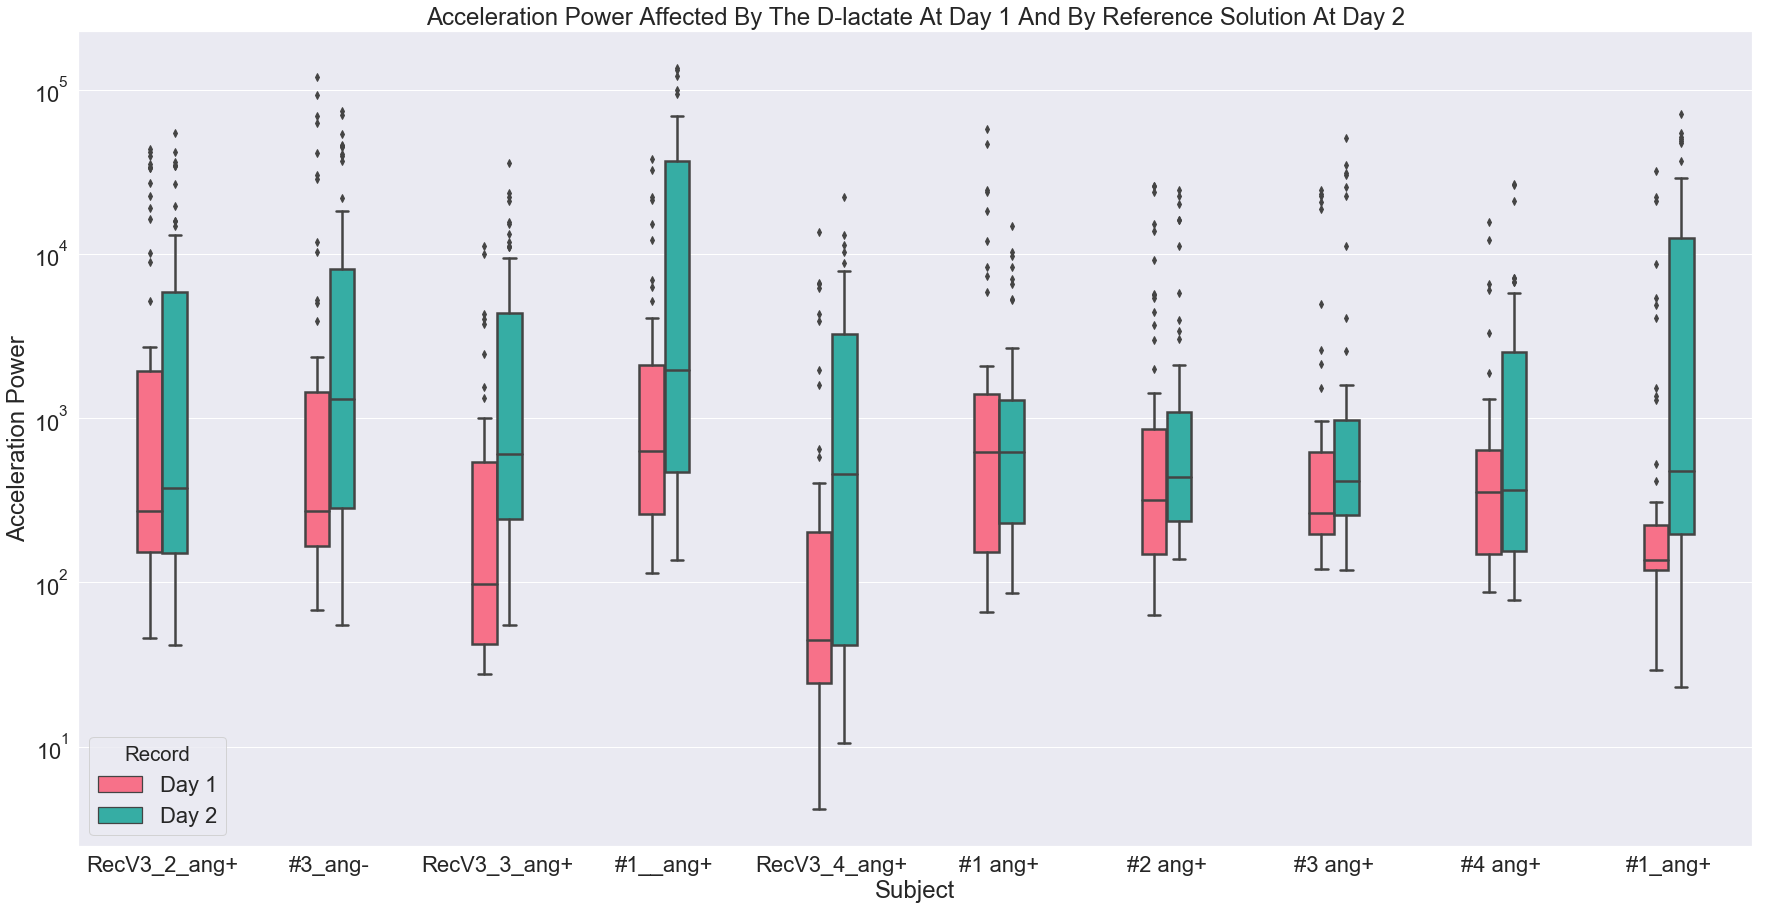

In [114]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Subject", 
            y="Acceleration", 
            hue="Record",
            hue_order=['Day 1', 'Day 2'],
            palette="husl",
            linewidth=2.5,
            saturation=1,
            width=0.3,
            data=d_lactate, 
            ax=ax)

plt.title("Acceleration Power Affected By The D-lactate At Day 1 And By Reference Solution At Day 2")
ax.set_ylabel("Acceleration Power")
show()

In [423]:
from scipy.stats import fisher_exact

/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.
/Users/vasilyminkov/anaconda3/lib/pyt

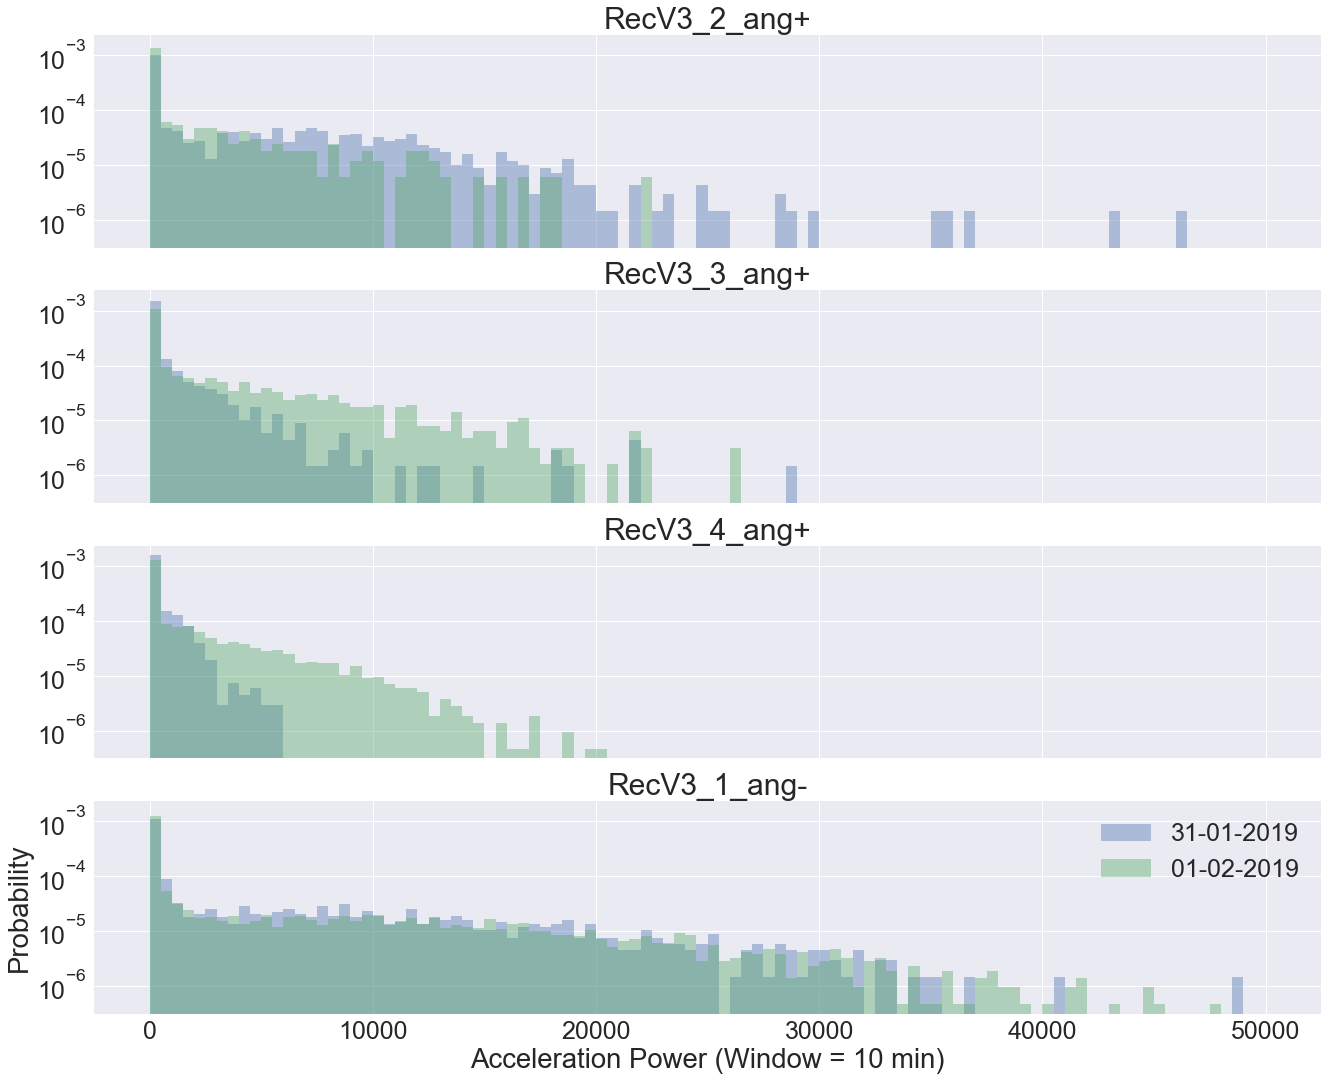

In [38]:
f, ax = plt.subplots(4, 1, sharex=True, sharey=True)

for subject_id, subject_name in enumerate(data["Subject"].unique()):
    
    subject = data[data["Subject"]==subject_name]
    ax[subject_id].set(yscale="log")
    ax[subject_id].set_title(subject_name)
    
    for record_name in subject["Record"].unique()[::-1]:        
        
        sns.distplot(
            subject[subject["Record"]==record_name]["Acceleration"].as_matrix(),
            kde=False,
            bins=100,
            norm_hist=True,
            ax=ax[subject_id],
            hist_kws={"range": [0, 5e4], "label":record_name},
        )
        
    legend()
    xlabel("Acceleration Power (Window = 10 min)")
    ylabel("Probability")

In [15]:
mask = {"Channel 1 Power 4-8":"Channel #1 4-8 Hz Power", 
        "Channel 2 Power 4-8":"Channel #2 4-8 Hz Power"}

d_lactate = d_lactate.rename(index=str, columns=mask)
# l_lactate = l_lactate.rename(index=str, columns=mask)

NameError: name 'l_lactate' is not defined

In [61]:
d_lactate = d_lactate[d_lactate["Minutes"] > 50]

In [10]:
def select_test(data, result):

    li = []

    for sub in data["Subject"].unique():
        if sub[-1] == result:
            li.append(sub)

    selected = data[data["Subject"].isin(li)]
    
    return selected

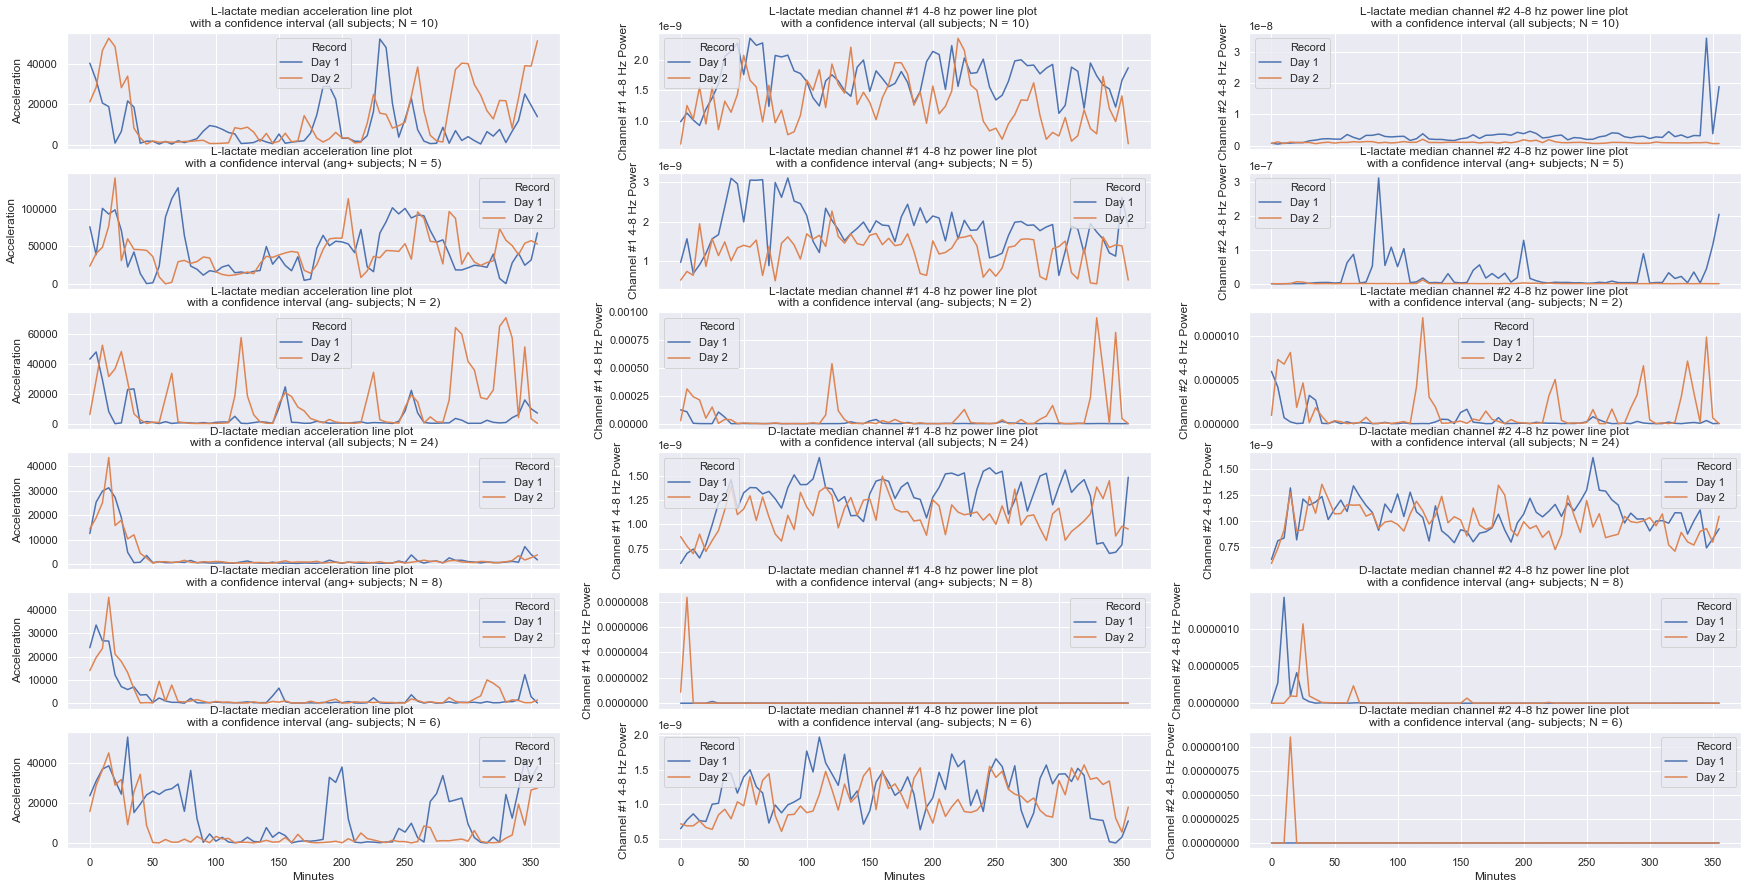

In [94]:
pylab.rcParams['figure.figsize'] = (30, 15)
sns.set(font_scale=1)

title = "{key} median {feature} line plot ({kind} subjects; N = {N})"

f, ax = plt.subplots(6, 3, sharex=True)
row = 0 
column = 0

for feature in ["Acceleration", "Channel #1 4-8 Hz Power", "Channel #2 4-8 Hz Power"]:
    for key, value in {"L-lactate": l_lactate, "D-lactate": d_lactate}.items():
        for kind, arr in {"all": value, "ang+": select_test(value, "+"), "ang-": select_test(value, "-")}.items():
            ax[row, column].set_title(title.format(key=key, feature=feature.lower(), kind=kind, N=arr['Subject'].unique().shape[0]))
            sns.lineplot(x="Minutes", y=feature, hue="Record", data=arr, ax=ax[row, column], estimator=np.median, ci=None)
            row += 1
    row = 0
    column += 1

savefig('median.pdf', dpi=1000)

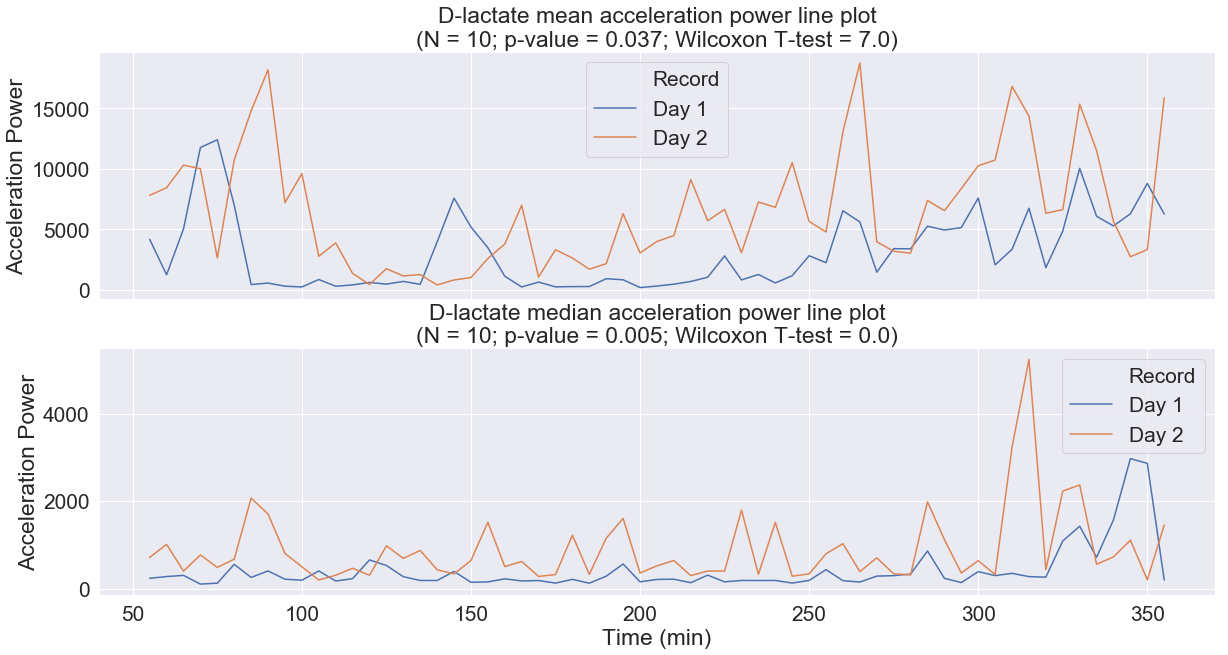

In [144]:
pylab.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=1.9)

title = "{key} {estimator} {feature} power line plot\n(N = {N}; p-value = {p}; Wilcoxon T-test = {t})"

f, ax = plt.subplots(2, 1, sharex=True)
feature = "Acceleration"
hue_order=["Day 1", "Day 2"]

results = {}

for record in d_lactate["Record"].unique():
    arr = []
    for subject in d_lactate["Subject"].unique():
        arr.append(d_lactate[(d_lactate["Subject"] == subject) & (d_lactate["Record"] == record)]["Acceleration"].mean())
    results[record] = arr
    
test = wilcoxon(results["Day 2"], results["Day 1"])
results = pd.DataFrame(results)

ax[0].set_title(title.format(key="D-lactate", estimator="mean", feature=feature.lower(), N=d_lactate['Subject'].unique().shape[0], t=test[0], p=round(test[1], 3)))
sns.lineplot(x="Minutes", y=feature, hue="Record", data=d_lactate, ax=ax[0], ci=None, hue_order=hue_order)
ax[0].set_ylabel("Acceleration Power")






for record in d_lactate["Record"].unique():
    arr = []
    for subject in d_lactate["Subject"].unique():
        arr.append(d_lactate[(d_lactate["Subject"] == subject) & (d_lactate["Record"] == record)]["Acceleration"].median())
    results[record] = arr
    
test = wilcoxon(results["Day 2"], results["Day 1"])
results = pd.DataFrame(results)
ax[1].set_title(title.format(key="D-lactate", estimator="median", feature=feature.lower(), N=d_lactate['Subject'].unique().shape[0], t=test[0], p=round(test[1], 3)))
sns.lineplot(x="Minutes", y=feature, hue="Record", data=d_lactate, ax=ax[1], ci=None, estimator=np.median, hue_order=hue_order)
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("Acceleration Power")

savefig('/Users/wassilyminkow/Desktop/d-lactate-mean-and-median.jpg', dpi=500)

In [ ]:
d_lactate[]

/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "Subject's Median Acceleration Power Distribution Differences Between Day 1 And 2\n(Wilcoxon T-test = 7.0; p-value = 0.037)")

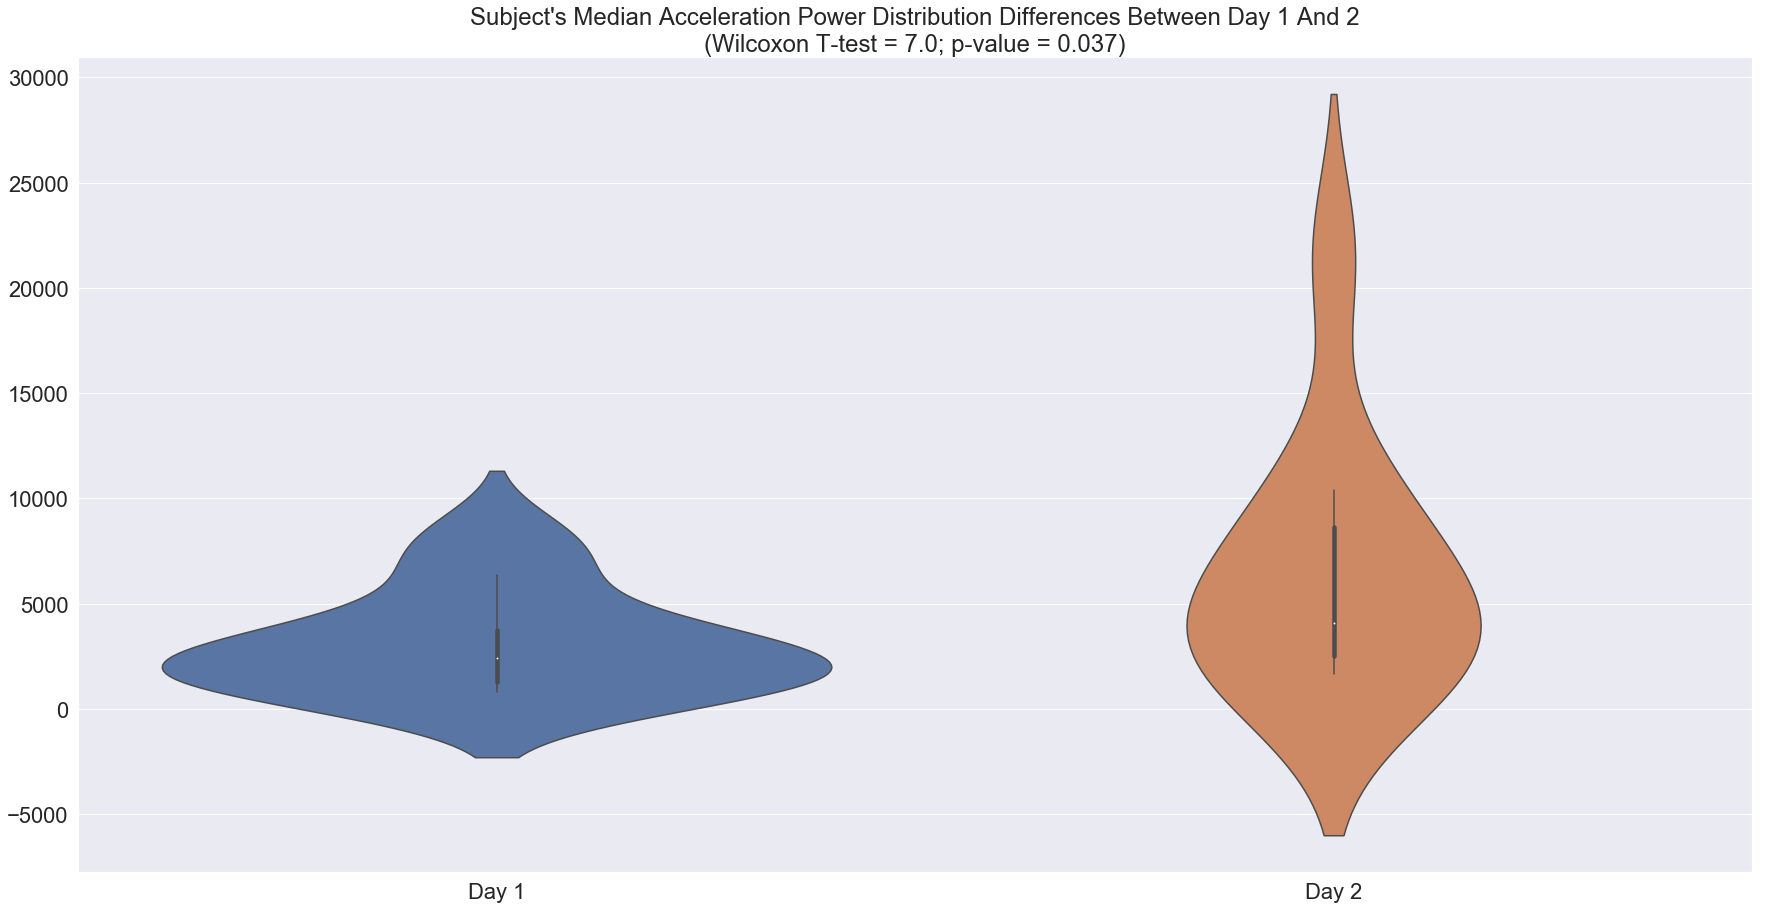

In [135]:
results = {}

for record in d_lactate["Record"].unique():
    arr = []
    for subject in d_lactate["Subject"].unique():
        arr.append(d_lactate[(d_lactate["Subject"] == subject) & (d_lactate["Record"] == record)]["Acceleration"].mean())
    results[record] = arr
    
test = wilcoxon(results["Day 2"], results["Day 1"])
results = pd.DataFrame(results)

sns.violinplot(data=results, order=["Day 1", "Day 2"], split=True)
plt.title(f"Subject's Median Acceleration Power Distribution Differences Between Day 1 And 2\n(Wilcoxon T-test = {test[0]}; p-value = {round(test[1], 3)})")

In [111]:
results = pd.DataFrame({"Day":[], "Mean Power":[], "Median Power":[]})

for record in d_lactate["Record"].unique():
    
    mean = []
    median = []
    
    for subject in d_lactate["Subject"].unique():
        
        mean.append(d_lactate[(d_lactate["Subject"] == subject) & (d_lactate["Record"] == record)]["Acceleration"].mean())
        median.append(d_lactate[(d_lactate["Subject"] == subject) & (d_lactate["Record"] == record)]["Acceleration"].median())

    results = pd.concat([results, pd.DataFrame({"Day": [record for i in range(len(mean))], "Mean Power": mean, "Median Power": median})])

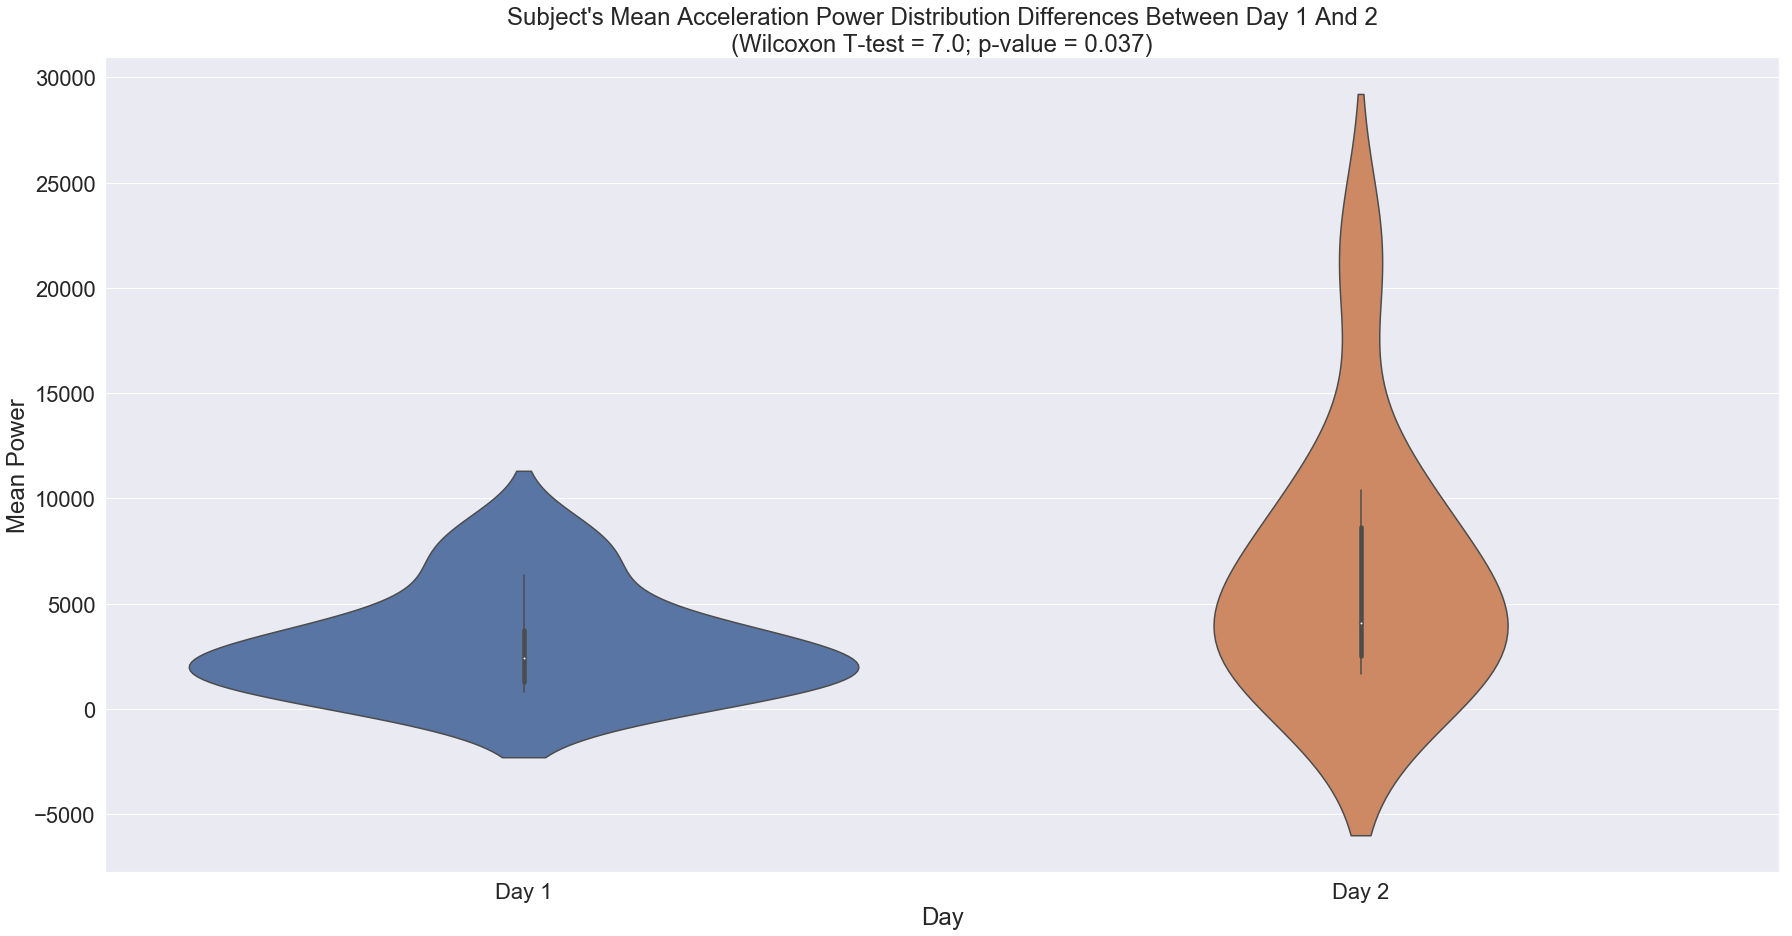

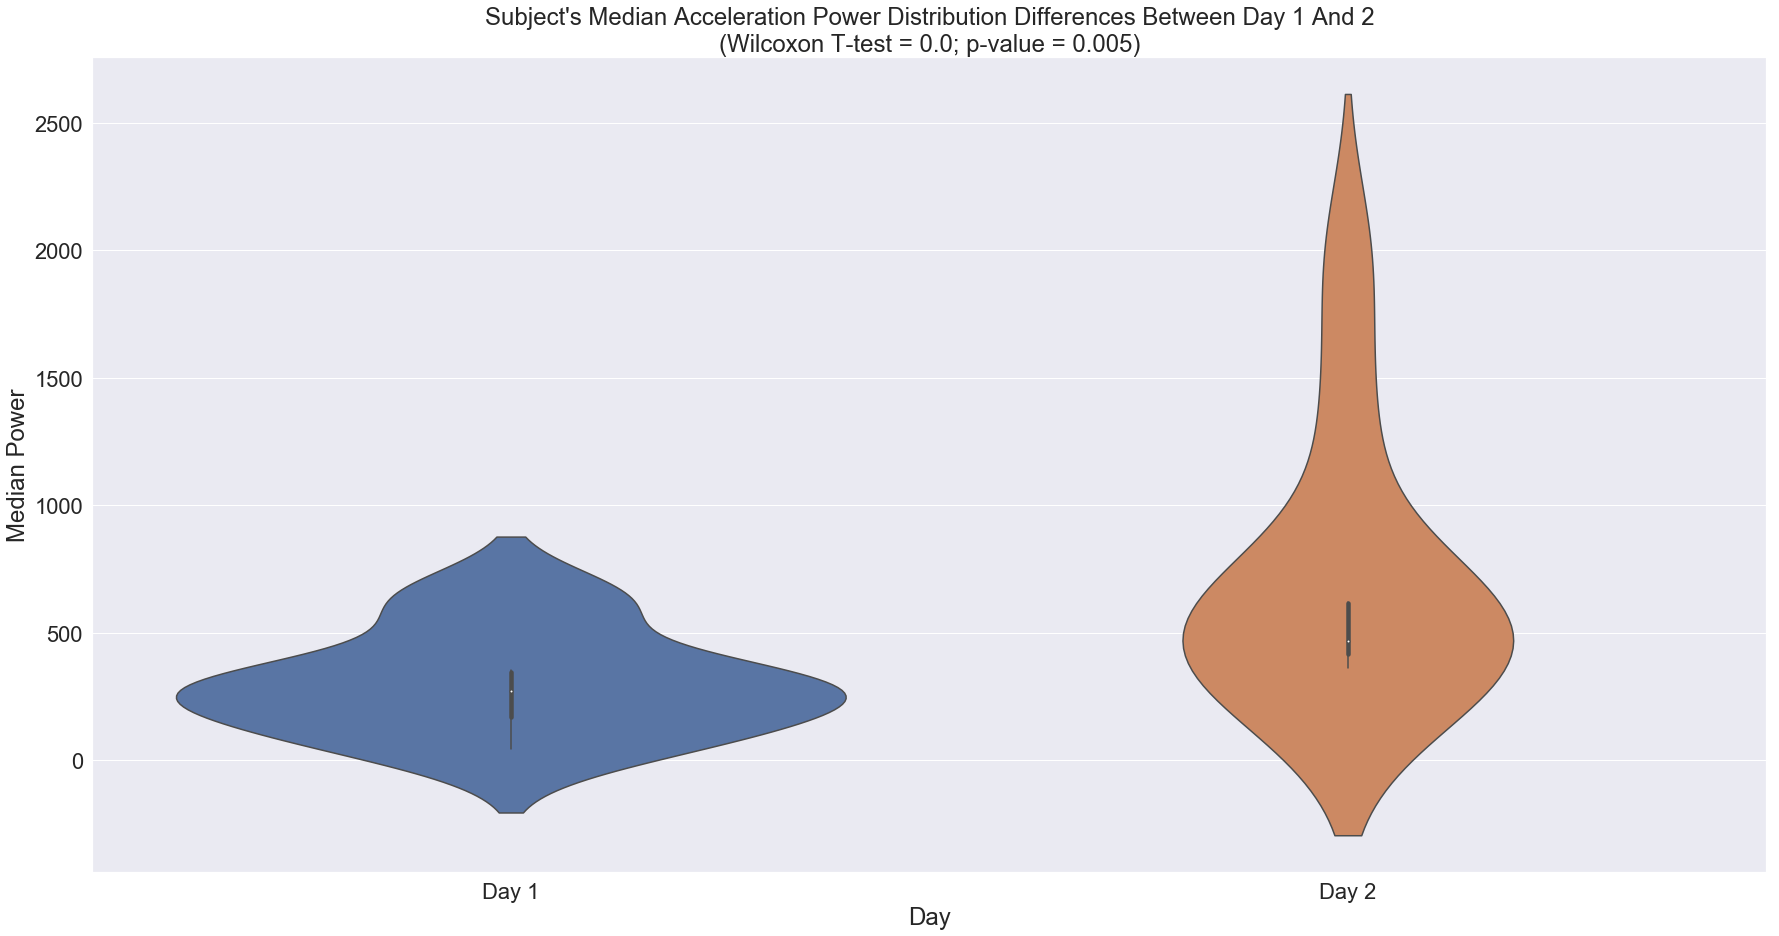

In [131]:
pylab.rcParams['figure.figsize'] = (30, 15)
sns.set(font_scale=2)

test = wilcoxon(results[results["Day"] == "Day 1"]["Mean Power"], results[results["Day"] == "Day 2"]["Mean Power"])
plt.title(f"Subject's Mean Acceleration Power Distribution Differences Between Day 1 And 2\n(Wilcoxon T-test = {test[0]}; p-value = {round(test[1], 3)})")
sns.violinplot(x="Day", y="Mean Power", data=results, order=["Day 1", "Day 2"])
show()

test = wilcoxon(results[results["Day"] == "Day 1"]["Median Power"], results[results["Day"] == "Day 2"]["Median Power"])
plt.title(f"Subject's Median Acceleration Power Distribution Differences Between Day 1 And 2\n(Wilcoxon T-test = {test[0]}; p-value = {round(test[1], 3)})")
sns.violinplot(x="Day", y="Median Power", data=results, order=["Day 1", "Day 2"])
show()

In [74]:
sleep_scoring = pd.read_csv("/Users/wassilyminkow/Desktop/Sleep_Scoring_Data.csv")

In [8]:
sleep_scoring.head()

,Wake,SW,REM,Subject,Record,Hours
0,0.533,0.411,0.056,#2 ang+,D-lactate,15
1,0.078,0.750,0.172,#2 ang+,D-lactate,16
2,0.344,0.533,0.122,#2 ang+,D-lactate,17
3,0.100,0.772,0.128,#2 ang+,D-lactate,18
4,0.311,0.522,0.167,#2 ang+,D-lactate,19


In [9]:
sleep_scoring

,Wake,SW,REM,Subject,Record,Hours
0,0.533,0.411,0.056,#2 ang+,D-lactate,15
1,0.078,0.750,0.172,#2 ang+,D-lactate,16
2,0.344,0.533,0.122,#2 ang+,D-lactate,17
3,0.100,0.772,0.128,#2 ang+,D-lactate,18
4,0.311,0.522,0.167,#2 ang+,D-lactate,19
5,0.450,0.417,0.133,#2 ang+,D-lactate,20
6,0.622,0.328,0.039,#2 ang+,Saline,15
7,0.194,0.650,0.156,#2 ang+,Saline,16
8,0.222,0.656,0.122,#2 ang+,Saline,17
9,0.450,0.489,0.061,#2 ang+,Saline,18


In [41]:
state = "SW"

results = pd.DataFrame({"Record":[], "Mean Power":[], "Median Power":[]})

for record in sleep_scoring["Record"].unique():
    
    mean = []
    median = []
    
    for subject in sleep_scoring["Subject"].unique():
        
        mean.append(sleep_scoring[(sleep_scoring["Subject"] == subject) & (sleep_scoring["Record"] == record)][state].mean())
        median.append(sleep_scoring[(sleep_scoring["Subject"] == subject) & (sleep_scoring["Record"] == record)][state].median())

    results = pd.concat([results, pd.DataFrame({"Record": [record for i in range(len(mean))], "Mean Power": mean, "Median Power": median})])

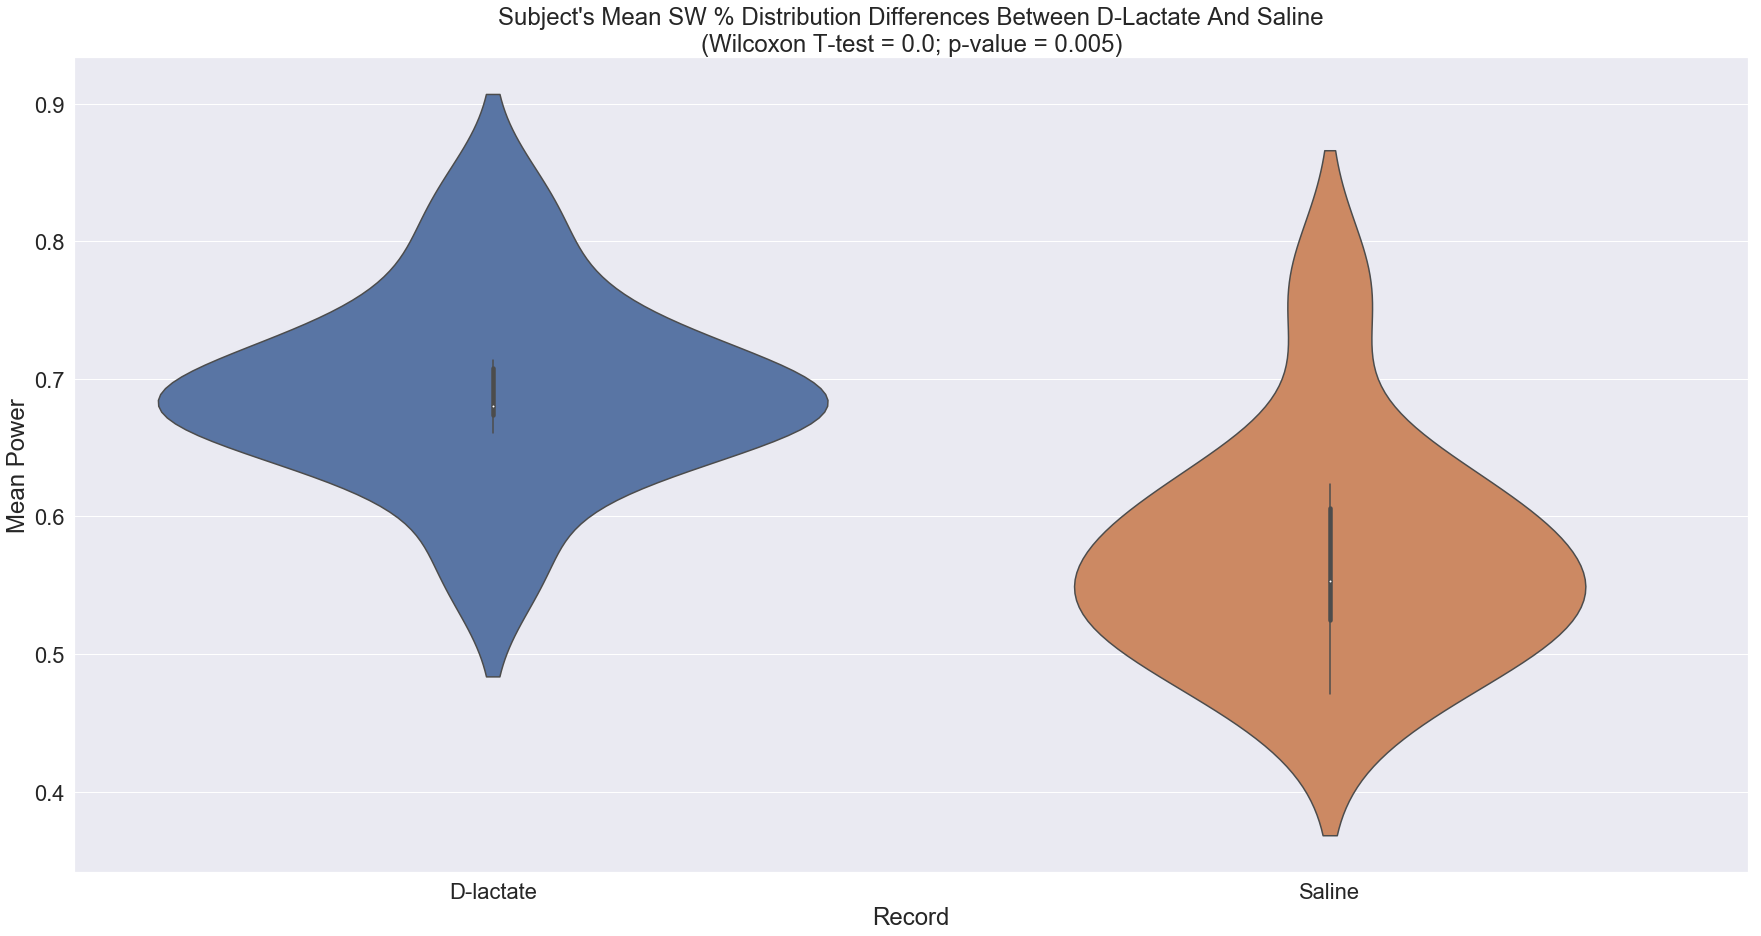

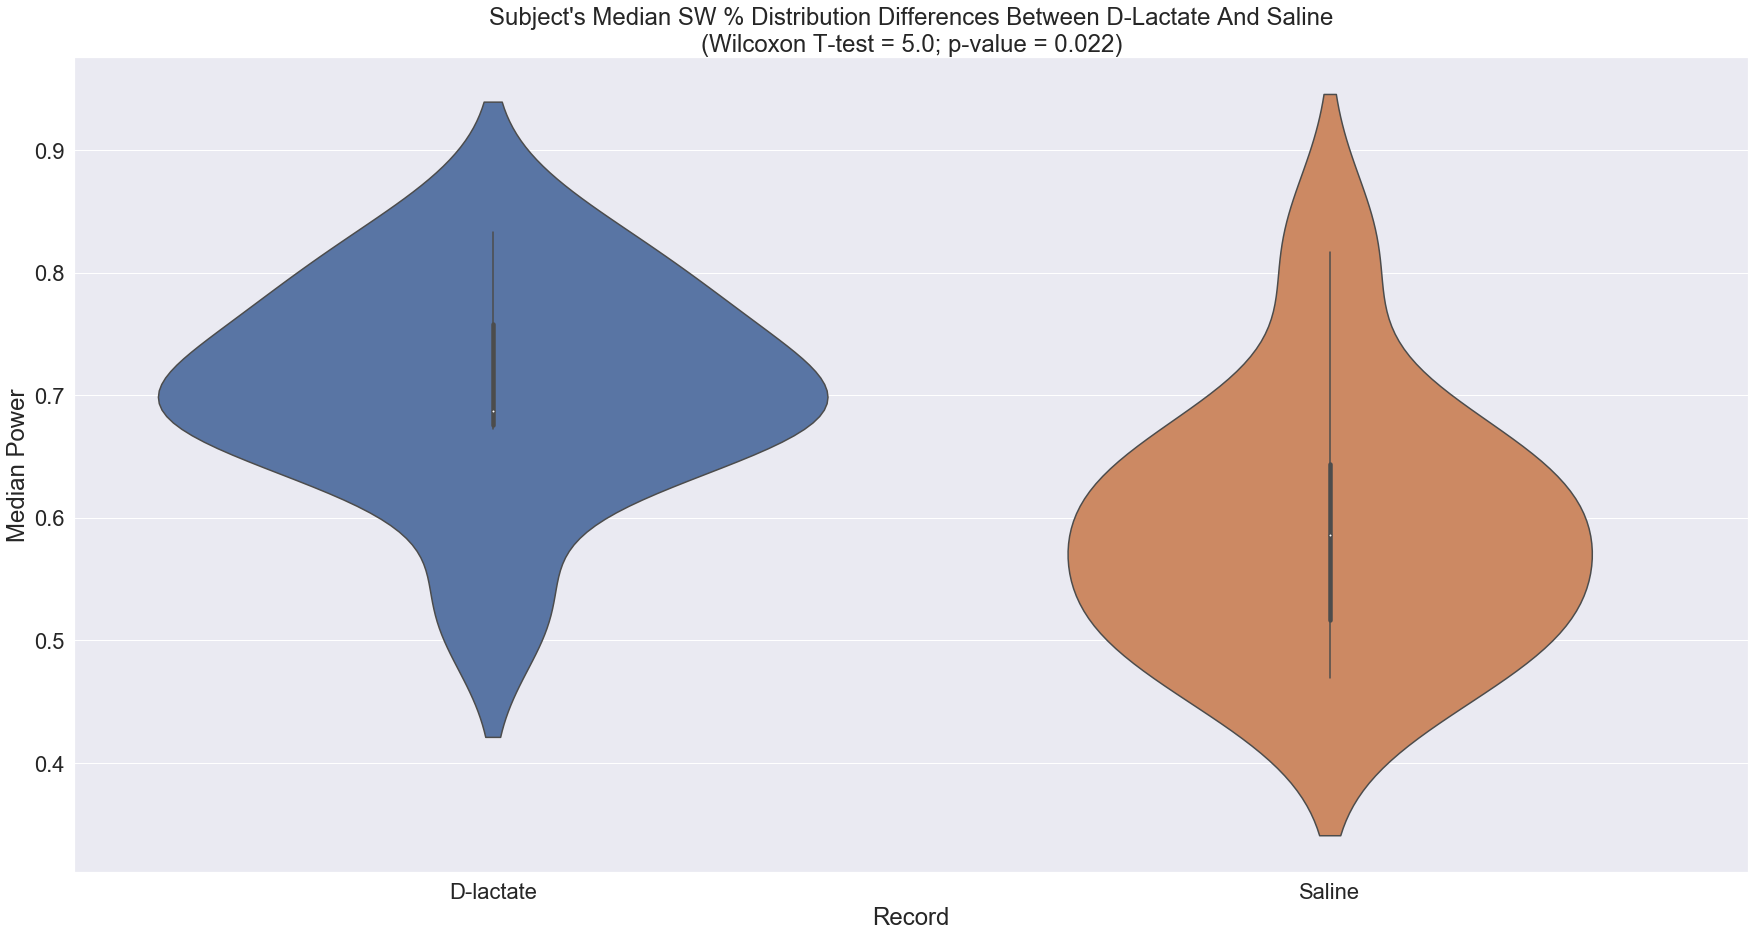

In [42]:
pylab.rcParams['figure.figsize'] = (30, 15)
sns.set(font_scale=2)

test = wilcoxon(results[results["Record"] == "Saline"]["Mean Power"], results[results["Record"] == "D-lactate"]["Mean Power"])
plt.title(f"Subject's Mean {state} % Distribution Differences Between D-Lactate And Saline\n(Wilcoxon T-test = {test[0]}; p-value = {round(test[1], 3)})")
sns.violinplot(x="Record", y="Mean Power", data=results)
show()

test = wilcoxon(results[results["Record"] == "Saline"]["Median Power"], results[results["Record"] == "D-lactate"]["Median Power"])
plt.title(f"Subject's Median {state} % Distribution Differences Between D-Lactate And Saline\n(Wilcoxon T-test = {test[0]}; p-value = {round(test[1], 3)})")
sns.violinplot(x="Record", y="Median Power", data=results)
show()

In [37]:
wake = results[results["Record"] == "Saline"]["Mean Power"] - results[results["Record"] == "D-lactate"]["Mean Power"]

In [40]:
rem = results[results["Record"] == "Saline"]["Mean Power"] - results[results["Record"] == "D-lactate"]["Mean Power"]

In [43]:
sw = results[results["Record"] == "Saline"]["Mean Power"] - results[results["Record"] == "D-lactate"]["Mean Power"]

In [44]:
mean = pd.concat([wake, sw, rem], axis = 1)

In [46]:
mean.columns = ["Wake", "SW", "REM"]

Text(0.5, 1.0, 'Distributions Of Sleep States Differences Between Saline And D-Lactate')

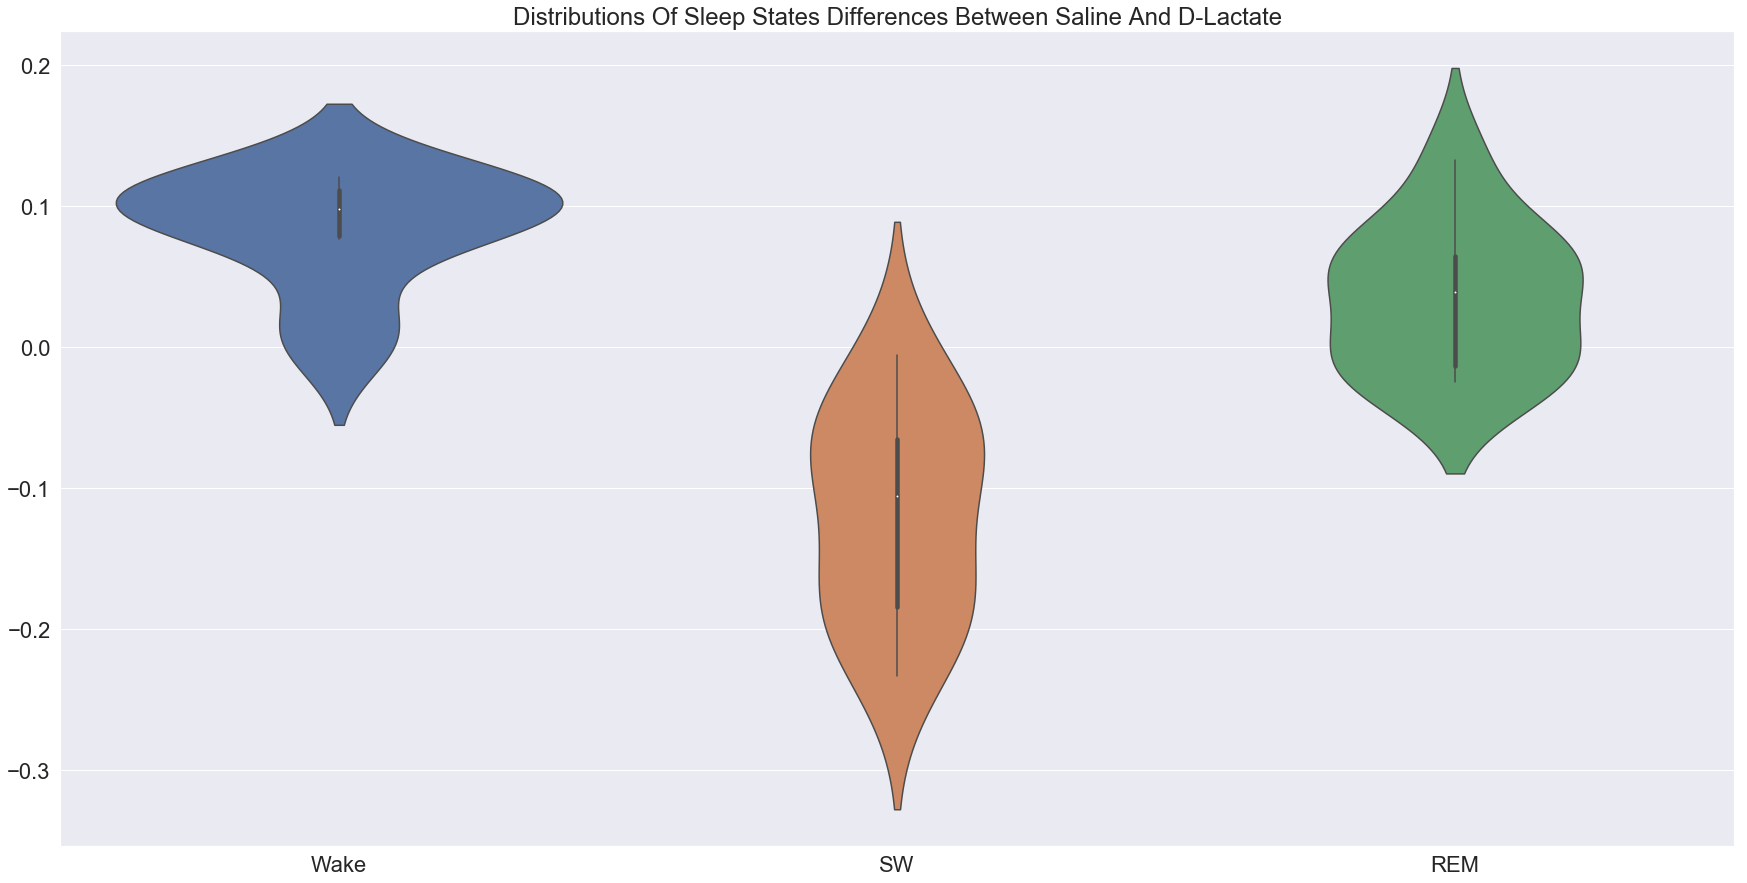

In [51]:
sns.violinplot(data=mean)
plt.title("Distributions Of Sleep States Differences Between Saline And D-Lactate")

In [108]:
wake = sleep_scoring.iloc[:,[0, 3, 4, 5]].rename(index=str, columns={"Wake":"Percentage"}) 
wake["State"] = "Wake"

sw = sleep_scoring.iloc[:,[1, 3, 4, 5]].rename(index=str, columns={"SW":"Percentage"})
sw["State"] = "Slow Wave Sleep"

rem = sleep_scoring.iloc[:,[2, 3, 4, 5]].rename(index=str, columns={"REM":"Percentage"})
rem["State"] = "Paradoxical Sleep"

df = pd.concat([wake, sw, rem])
df = df.rename(index=str, columns={"Record":"Solution"})

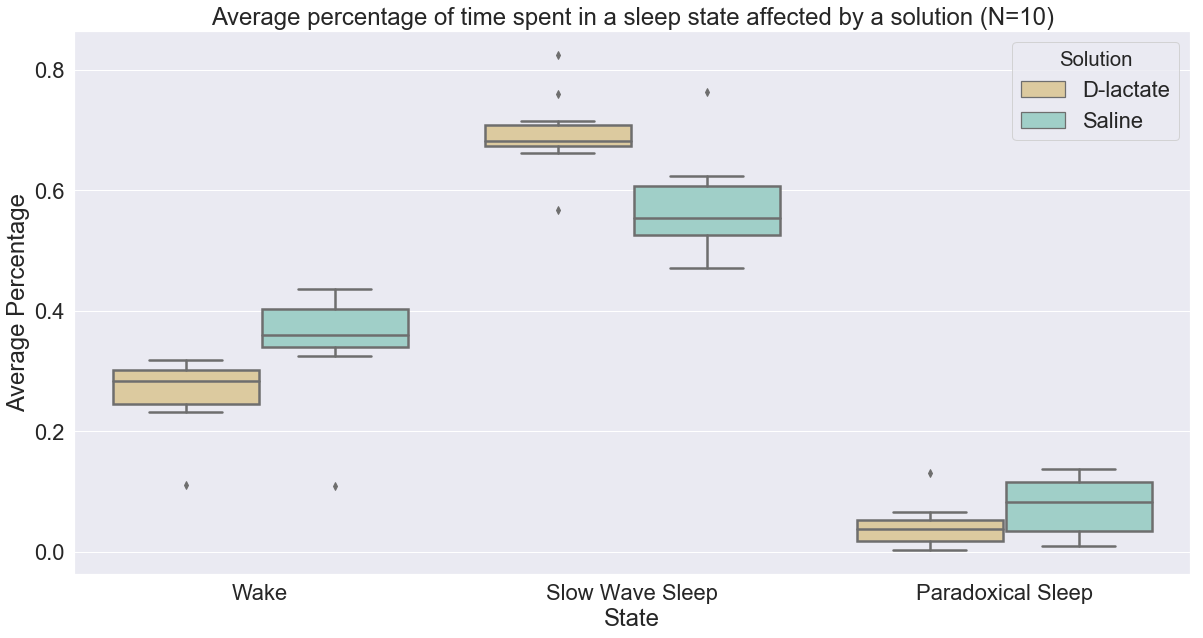

In [145]:
pylab.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=2)

sns.boxplot(x="State", y="Average Percentage", hue="Solution", data=means, linewidth=2.5, palette="BrBG")
plt.title("Average percentage of time spent in a sleep state affected by a solution (N=10)")

savefig('/Users/wassilyminkow/Desktop/Average_percentage.jpg', dpi=500)

In [126]:
means = []
for sub in df["Subject"].unique():
    for st in df["State"].unique():
        for sol in df["Solution"].unique():
            means.append([sub, st, sol, df[(df["Subject"]==sub) & (df["State"]==st) & (df["Solution"]==sol)]["Percentage"].mean()])

In [128]:
means = pd.DataFrame(means, columns=["Subject", "State", "Solution", "Average Percentage"])

In [129]:
means

,Subject,State,Solution,Average Percentage
0,#2 ang+,Wake,D-lactate,0.302667
1,#2 ang+,Wake,Saline,0.325400
2,#2 ang+,Slow Wave Sleep,D-lactate,0.567500
3,#2 ang+,Slow Wave Sleep,Saline,0.562400
4,#2 ang+,Paradoxical Sleep,D-lactate,0.129667
5,#2 ang+,Paradoxical Sleep,Saline,0.110000
6,#3 ang+,Wake,D-lactate,0.318500
7,#3 ang+,Wake,Saline,0.435167
8,#3 ang+,Slow Wave Sleep,D-lactate,0.660833
9,#3 ang+,Slow Wave Sleep,Saline,0.471333
